# Loss fucntion with all constraints

In this notebook we will have a look at a loss function that has all the constraints of the system. Note that our system is overconstrained as we can obtain the information of the neutrino from the forward detector measurements of the protons and from the invariant mass of the W boson decying leptonically.


## The loss function

The equation of the loss function we are using is : 

$$ LF =\frac{A\left(p_z^{total}\right)^2}{\sigma_{p^{\left(1\right)}}^2 + \sigma_{p^{\left(2\right)}}^2} - \frac{B}{(W-W_0)^2 + C(W_0)^2} \tag 1$$

Where $p_z^{total}$ is the total z-component of momentum (protons and decay products). Note that this is a function of $\nu_z$. $\sigma_{p^{\left(1\right)}}$ and $\nu_z$. $\sigma_{p^{\left(2\right)}}$ are the smearing standard deviations of protons 1 and 2 respectively. $W$ is the invaraint mass of the w boson in terms of $\nu_z$ and $W_0$ is the value of thr invariant mass of the W boson:
$$W\left(\nu _z\right)=\sqrt{2\left|\mathbf{p}_{\mu }\right|\sqrt{\nu _x^2+\nu _y^2+\nu _z^2}-2\left(\mu _x\nu _x+\mu _y\nu _y+\mu _z\nu _z\right)}\tag 2$$

Note that :
$$\sigma_{x_i} = 2.5 + {50}\times\left( \frac{6500 - |P_z|}{|P_z|}\right) \tag3  $$

also $ A, B $ are normalisation terms, and $ C $ is the factor that affects the width of two minimums.

$$L =\frac{A\left(p_z^{other\ particles} + \nu_z\right)^2}{\sigma_{p^{\left(1\right)}}^2 + \sigma_{p^{\left(2\right)}}^2} - \frac{B}{(W^2-W_0^2)^2 + 4\times W^2},\ 
W=\sqrt{2\left|\mathbf{p}_{\mu }\right|\sqrt{\nu _x^2+\nu _y^2+\nu _z^2}-2\left(\mu _x\nu _x+\mu _y\nu _y+\mu _z\nu _z\right)}\ \ \ \&\ \ \  \sigma_{p^{\left(i \right )}} = 2.5 + 50 \times\left(\frac{6500 - \mid p_z^{\left( i \right)} \mid}{p_z^{\left( i \right)}} \right)  $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.special import factorial
import scipy.optimize as opt
from scipy.optimize import fsolve

In [2]:
### Importing Data

ro_skip = []
for i in range(0,1000):
    skip0 = 0 + i*12
    skip1 = 1 + i*12
    skip2 = 2 + i*12
    ro_skip.append(skip0)
    ro_skip.append(skip1)
    ro_skip.append(skip2)


data = pd.read_table('evrecWWmu.dat',skiprows=ro_skip,delim_whitespace=True, names=['M.C.N', 'Unknown1', 'Unknown2', 'Unknown3','Unknown4','Unknown5','Px','Py','Pz','E','M','Unknown6','Unknown7'])

## Cutting the unnecessary values ##
data = data.loc[:, ~data.columns.isin(['Unknown1', 'Unknown2', 'Unknown3', 'Unknown4', 'Unknown5', 'Unknown6', 'Unknown7'])]

## Locating an event ##
event_name = {}
for x in range(1,1001):
    event_name["event{0}".format(x)] = ()

start_point = 0
end_point = 9

for name in event_name:
            
        globals()[name] = data.iloc[start_point:end_point].reset_index(drop=True)
        
        start_point = start_point + 9        
        end_point = start_point +9

## Analysis

In [7]:
def get_W_and_LF(event_index, vz_range):

    i = event_index
    vzrange = vz_range

    neutrinoPx = - globals()[f'event{i}'].Px[6] - globals()[f'event{i}'].Px[7] - globals()[f'event{i}'].Px[8] 
    neutrinoPy = - globals()[f'event{i}'].Py[6] - globals()[f'event{i}'].Py[7] - globals()[f'event{i}'].Py[8]
    testp_muon = np.sqrt(globals()[f'event{i}'].Px[6]**2 + globals()[f'event{i}'].Py[6]**2 + globals()[f'event{i}'].Pz[6]**2)
    sig1 = 2.5 + 50* ((6500 -abs(globals()[f'event{i}'].Pz[0]))/(6500))
    sig2 = 2.5 + 50* ((6500 -abs(globals()[f'event{i}'].Pz[1]))/(6500))

    w = 80.318

    
    def pztot(vz): #Total momentum along Z
        return globals()[f'event{i}'].Pz[0]+ globals()[f'event{i}'].Pz[1] + vz + globals()[f'event{i}'].Pz[6]+globals()[f'event{i}'].Pz[7]+globals()[f'event{i}'].Pz[8]

    def W(vz): # W function
        return np.sqrt(2*testp_muon*np.sqrt(neutrinoPx**2+neutrinoPy**2+vz**2)-2*(globals()[f'event{i}'].Px[6]*neutrinoPx+globals()[f'event{i}'].Py[6]*neutrinoPy+globals()[f'event{i}'].Pz[6]*vz))

    def LF1(vz): # First Loss Function Term
        return (pztot(vz)**2)/(sig1**2 + sig2**2)

    def LF2(vz,minimum_width): # Second Loss Function Term
        return 1/((W(vz)**2 - w**2)**2 + w**2 * minimum_width)
    
    # Normalisation
    first_term = LF1(vzrange)
    ft_max = max(first_term)
    ft_min = min(first_term)
    normalised_ft = (first_term - ft_min)/(ft_max - ft_min)

    second_term = LF2(vzrange, 4)
    st_max = max(second_term)
    st_min = min(second_term)
    normalised_st = (second_term - st_min)/(st_max - st_min)
    
    Loss_Function = normalised_ft - normalised_st
    
    return W(vzrange), Loss_Function

In [9]:
def showPlots(event_index, vz_range):
    # get parameters
    i = event_index
    w = 80.318 
    vzrange = vz_range
    
    W_value, LF_value = get_W_and_LF(event_index,vzrange)   
  
    # plot
    baseline = np.empty(10000)
    baseline.fill(w)
    
    fig, ax1 = plt.subplots(figsize=(16,9))
    
    ax2 = ax1.twinx()
    ax1.plot(vzrange,W_value,"g-")
    ax1.plot(vzrange,baseline,"y--")
    ax2.plot(vzrange,LF_value,"b-")
    
    ax1.set_xlabel('$P_z$ value')
    ax1.set_ylabel('$W(v_z)$', color='g')
    ax2.set_ylabel('$LF(v_z)$', color='b')
    ax2.set_title(f'Event{i}')
    ax1.grid()
    ax2.grid()
    plt.show()


In [10]:
def findMinimum(event_index, vz_range):
    W_value, LF_value = get_W_and_LF(event_index, vz_range)
    minimun_loc = np.where(LF_value == LF_value.min())
    
    vzrange = vz_range
    return vzrange[minimun_loc]

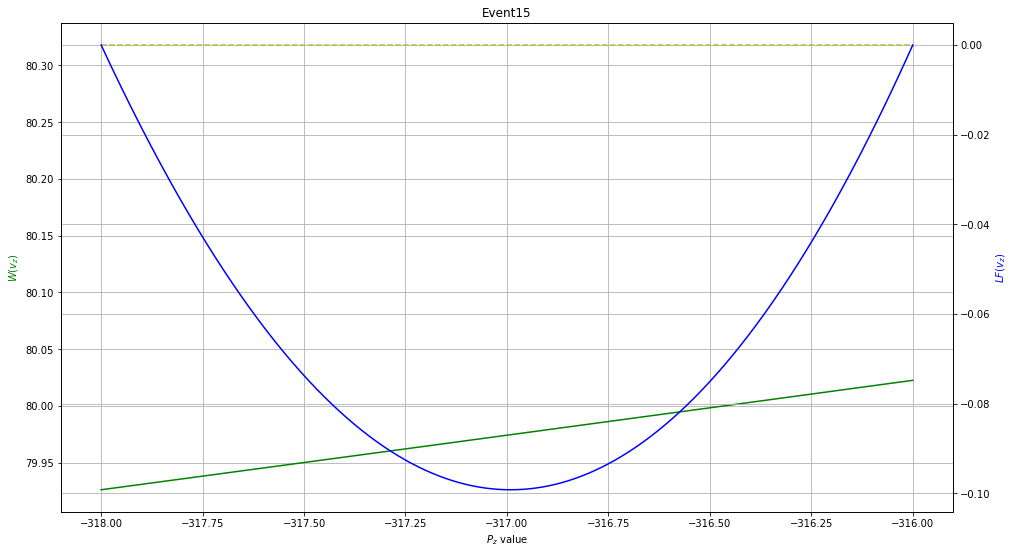

,M.C.N,Px,Py,Pz,E,M
0,2212,-0.161937,0.043663,6459.401020,6459.401090,9.382720e-01
1,2212,0.265005,0.774661,-5960.553900,5960.554030,9.382720e-01
2,93,-0.103068,-0.818323,-498.847116,580.044879,2.959779e+02
3,24,-14.516809,-77.590500,-438.616368,452.842492,8.031800e+01
4,-24,14.413740,76.772177,-60.230748,127.202387,8.031800e+01
5,-14,-13.198518,-92.316241,-320.098245,333.405723,3.303625e-06
6,13,-1.318291,14.725741,-118.518123,119.436770,1.056600e-01
7,14,16.665254,89.019564,-31.498085,95.887136,8.596304e-07
8,-13,-2.251514,-12.247388,-28.732663,31.315251,1.056600e-01


In [49]:
vz_range = np.linspace(-318,-316,10000)
showPlots(15,vz_range)
event15

## Test

In [41]:
prediction =[]
true_value =[]
vz_range = np.linspace(-2000,2000,200000)

for i in range(1,1001):
    pre_value = findMinimum(i,vz_range)
    prediction.append(pre_value)
    
    true_value.append(globals()[f'event{i}'].Pz[5])
    

In [42]:
n=0
wrong_index = []

for i in range(0,1000):
    
    prediction_value = np.array(prediction).reshape(1000)
    diff = prediction_value[i]-true_value[i]
    
    if diff > 10:
        n = n+1
        wrong_index.append(i+1)
        print("Wrong event index:",i+1,"Prediction:",prediction_value[i],"True Value:",true_value[i])
        
print("Total wrong reconsturctions:",n)

Wrong event index: 15 Prediction: -310.03155015775087 True Value: -320.098245
Wrong event index: 47 Prediction: 101.47050735253697 True Value: 89.2957438
Wrong event index: 195 Prediction: 500.39250196250987 True Value: 448.10762
Wrong event index: 232 Prediction: -623.5931179655897 True Value: -645.607123
Wrong event index: 264 Prediction: 364.97182485912435 True Value: 308.33453199999997
Wrong event index: 277 Prediction: -866.1743308716543 True Value: -876.651608
Wrong event index: 310 Prediction: 165.85082925414645 True Value: 155.697789
Wrong event index: 322 Prediction: 521.4726073630368 True Value: 464.163628
Wrong event index: 370 Prediction: -688.8134440672204 True Value: -720.25398
Wrong event index: 406 Prediction: -282.9314146570732 True Value: -294.274583
Wrong event index: 429 Prediction: -938.4546922734614 True Value: -1061.53147
Wrong event index: 469 Prediction: -298.69149345746723 True Value: -311.353701
Wrong event index: 470 Prediction: -276.0713803569017 True Value

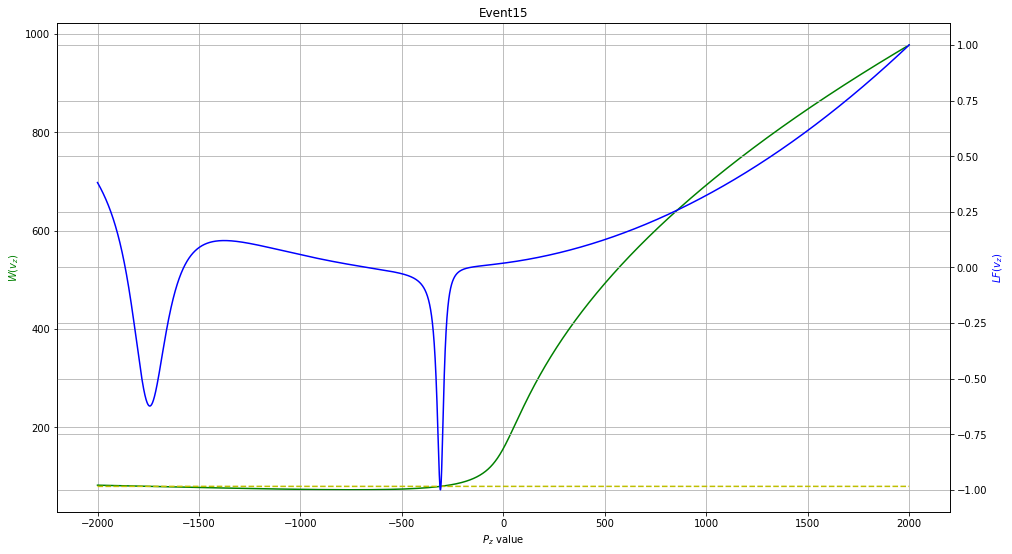

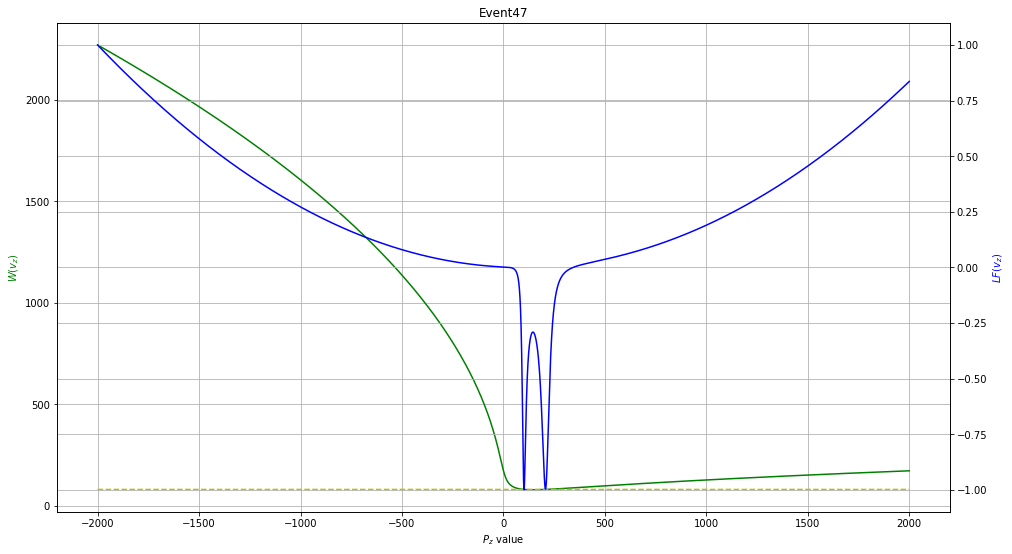

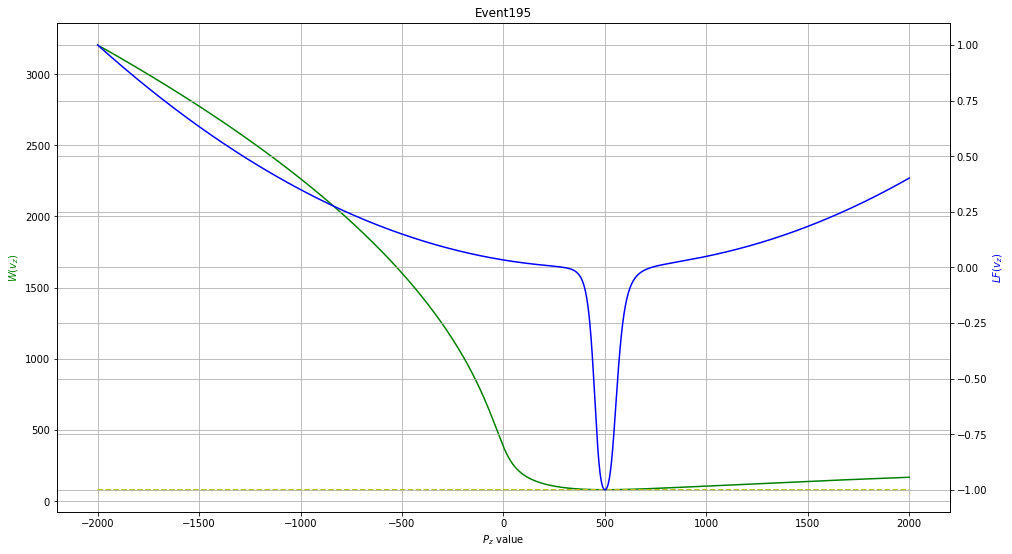

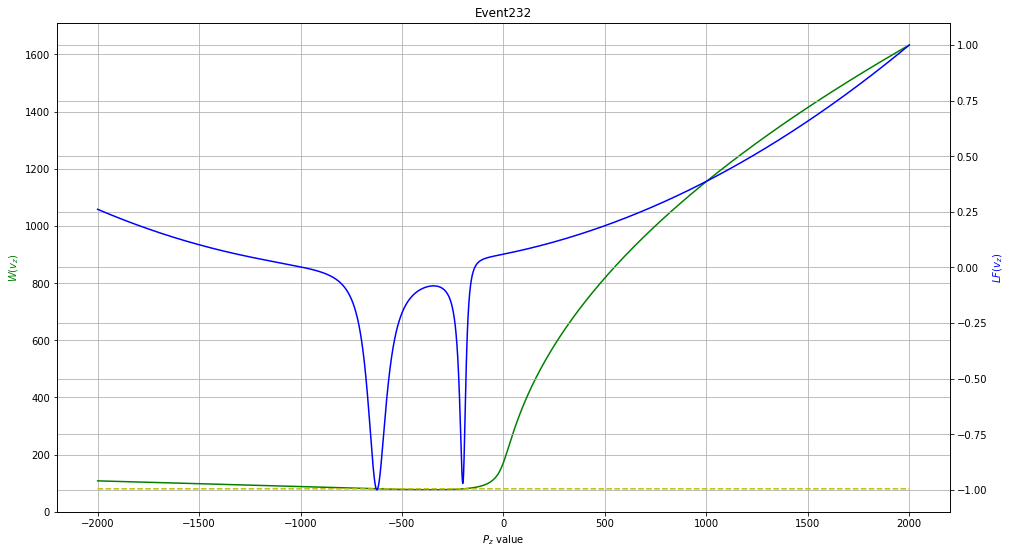

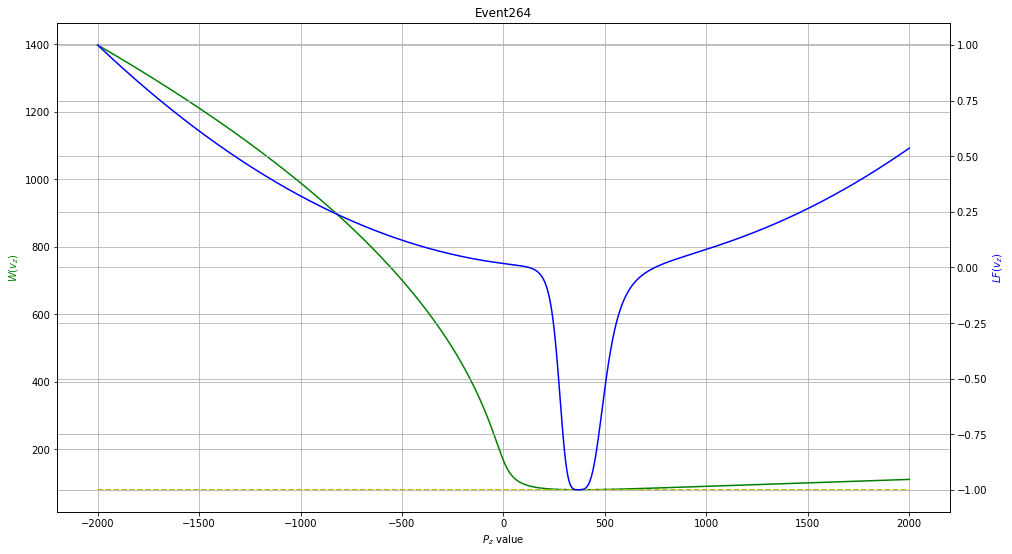

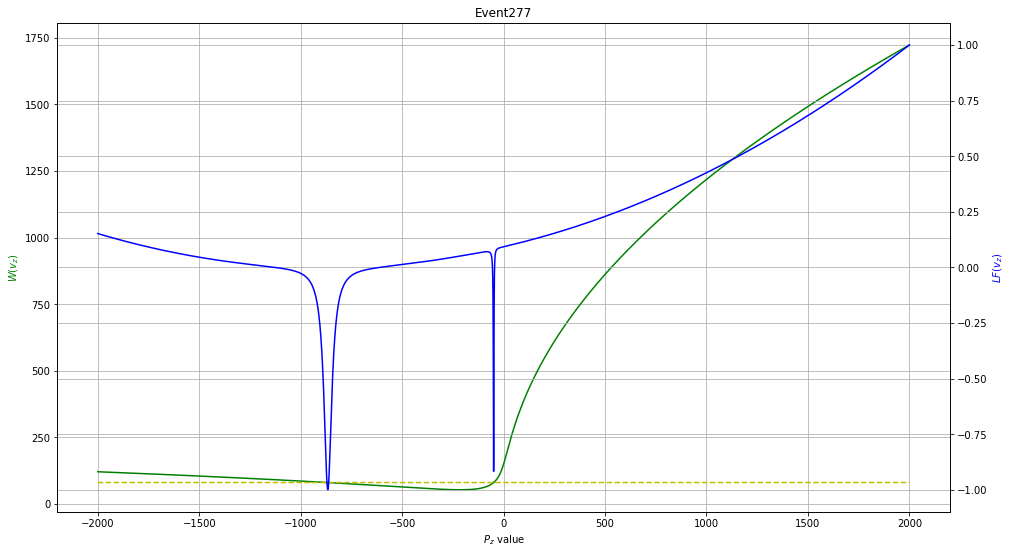

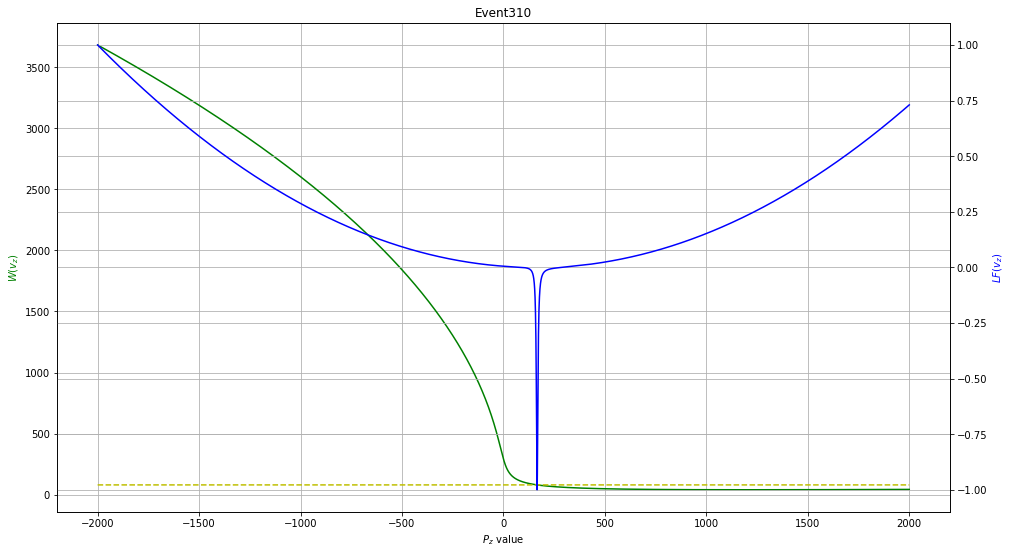

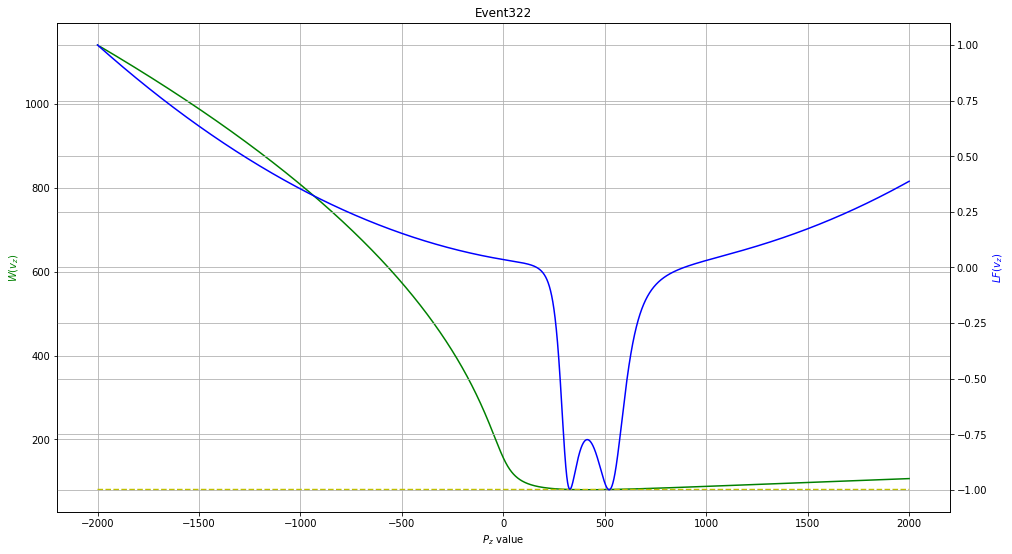

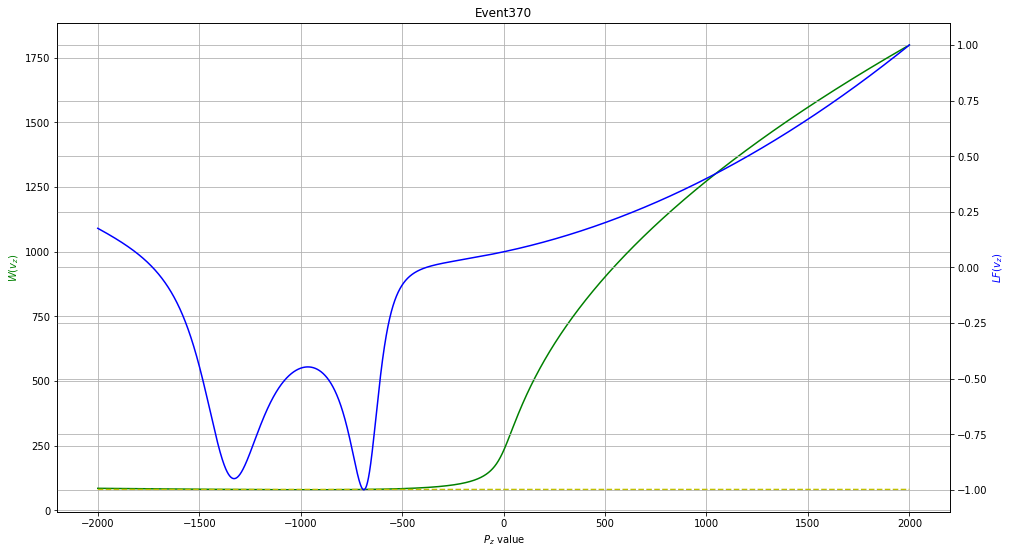

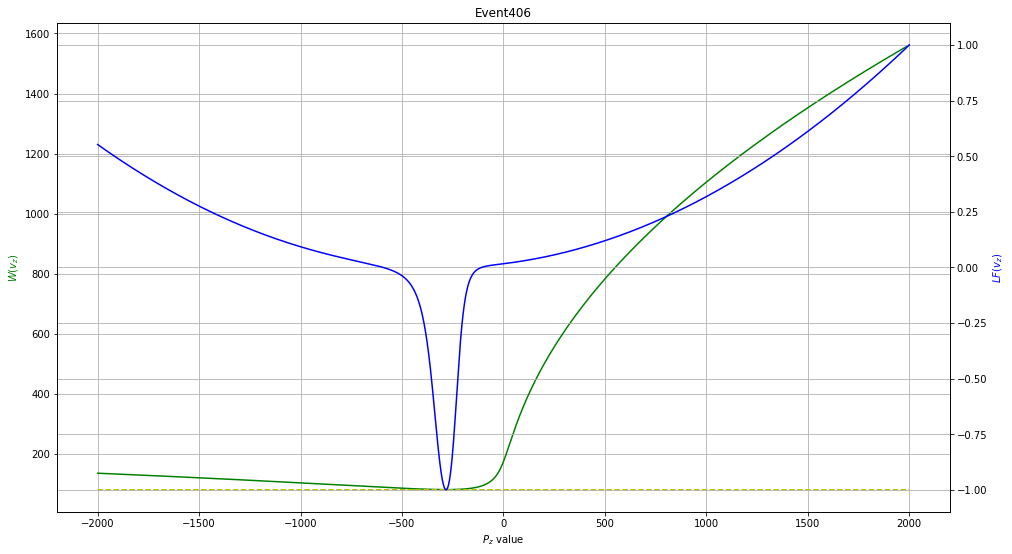

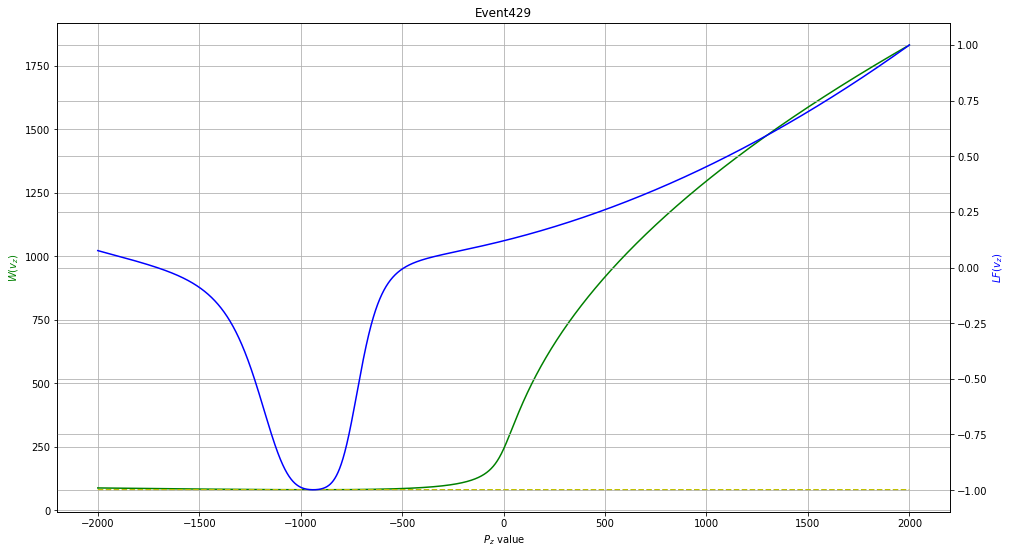

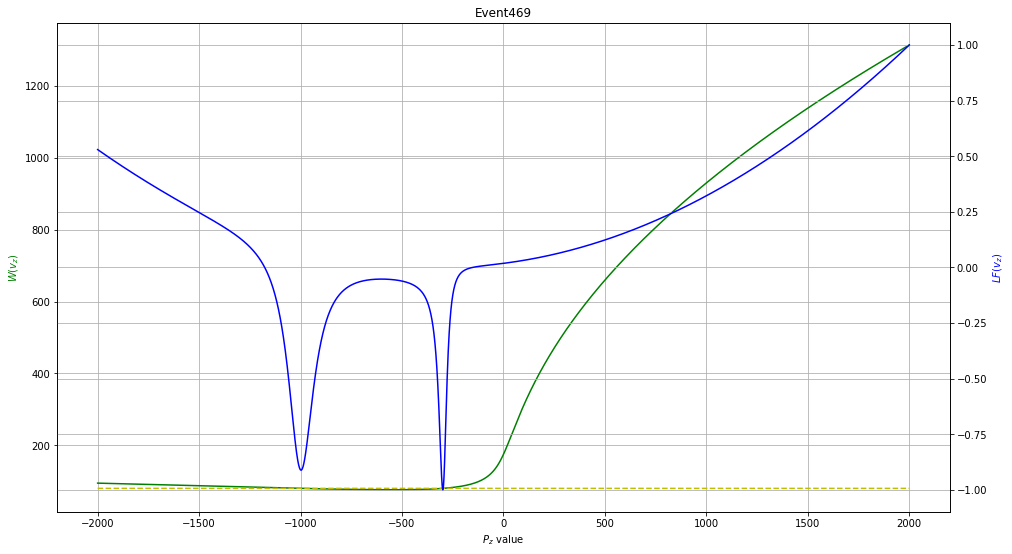

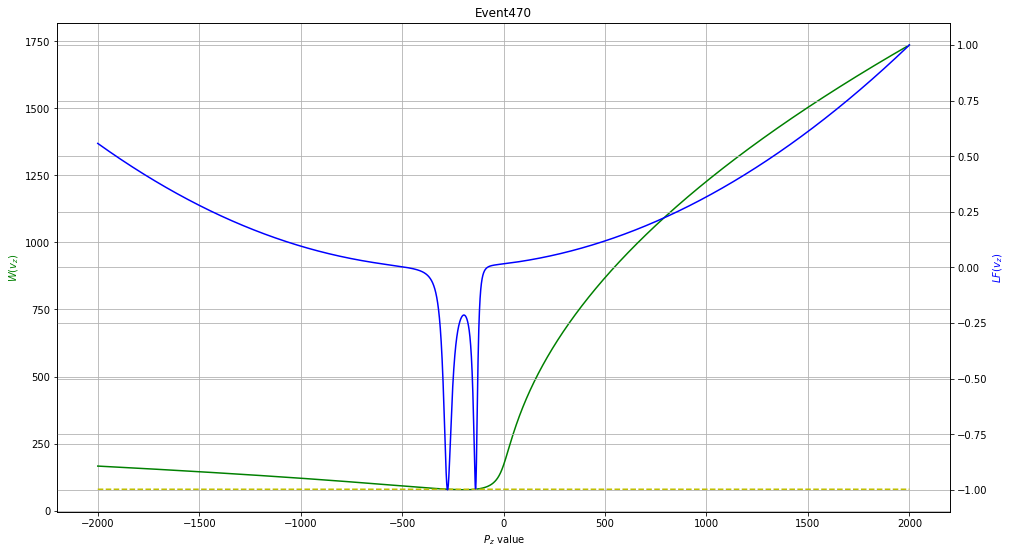

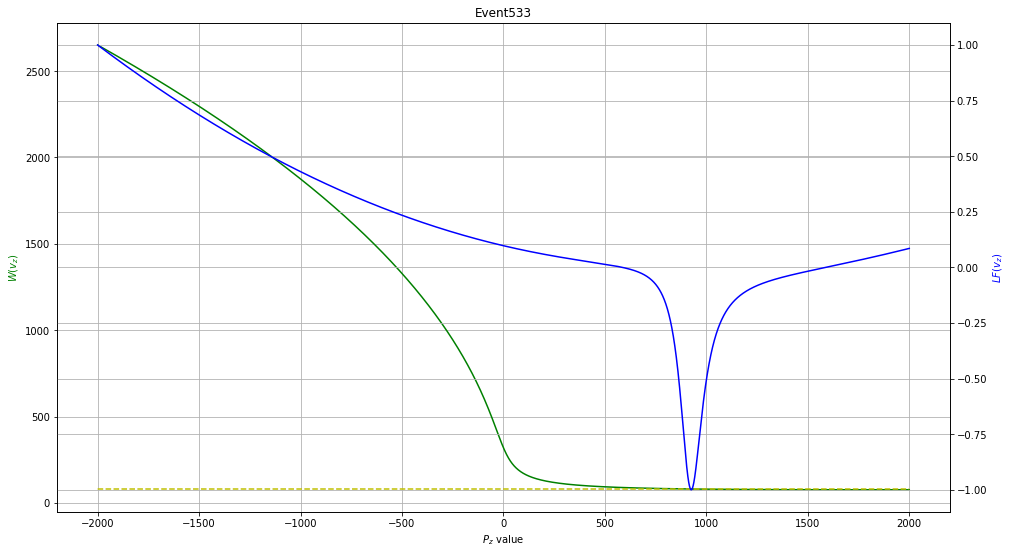

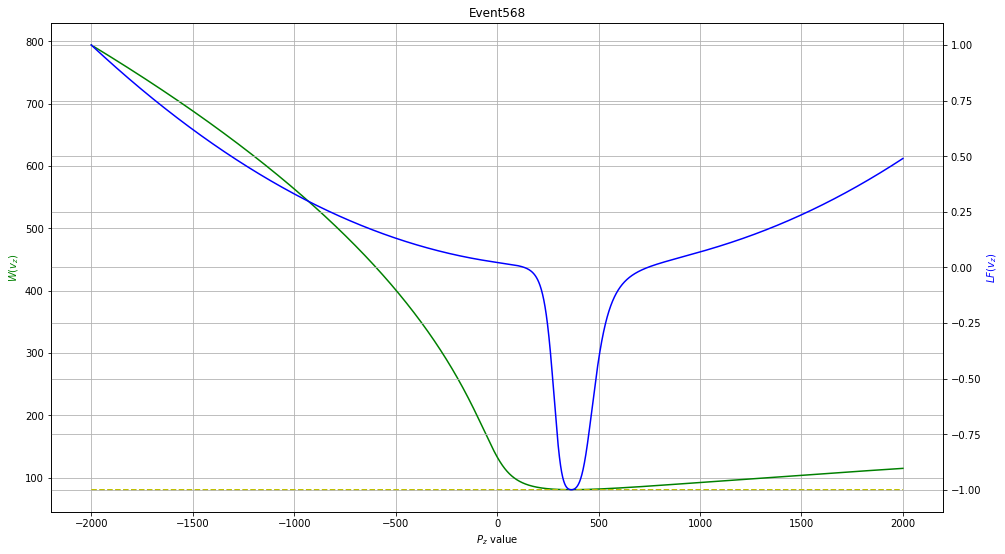

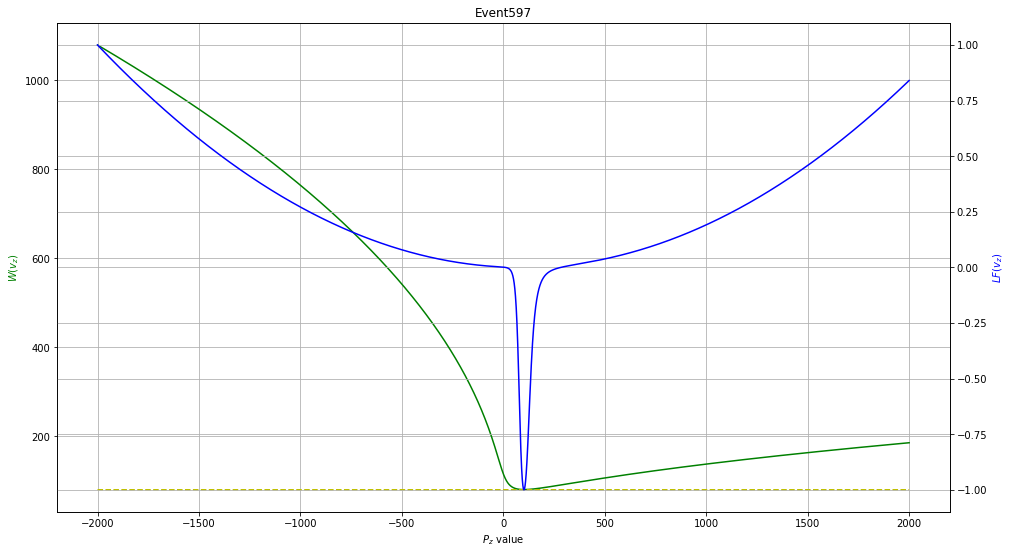

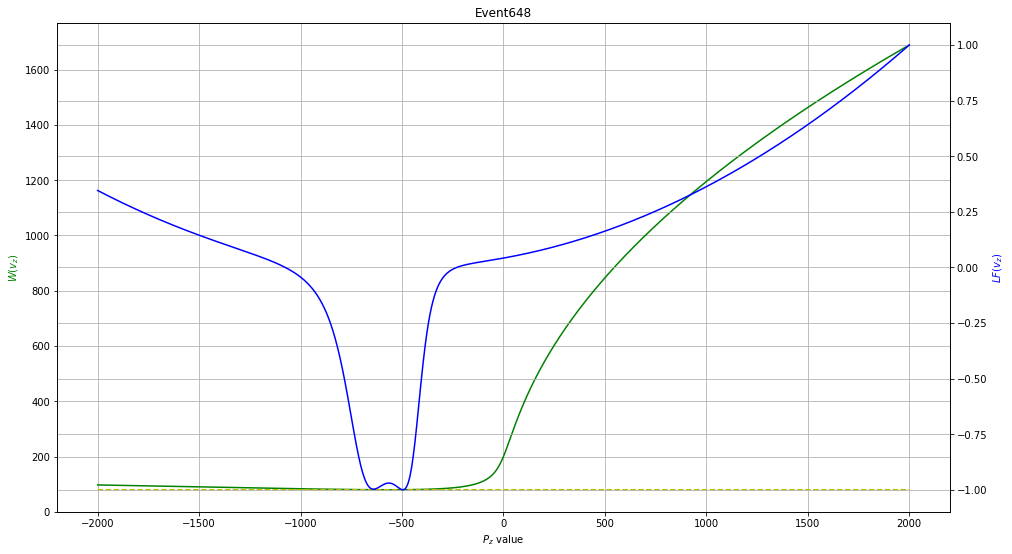

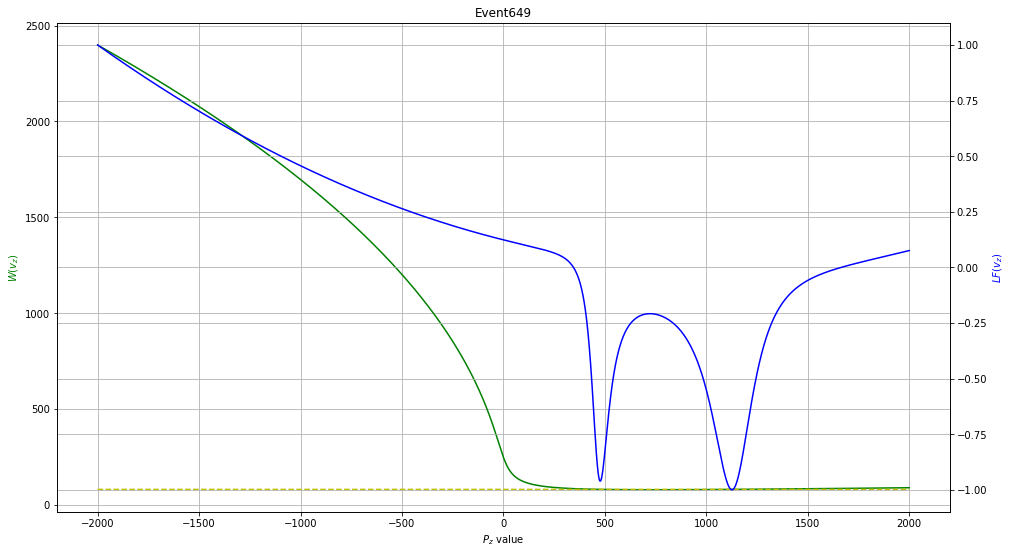

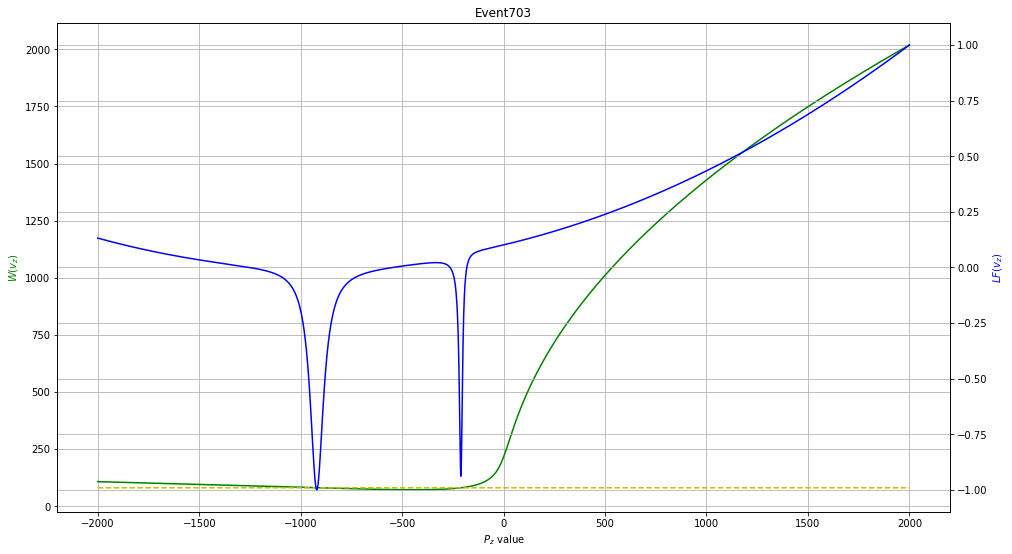

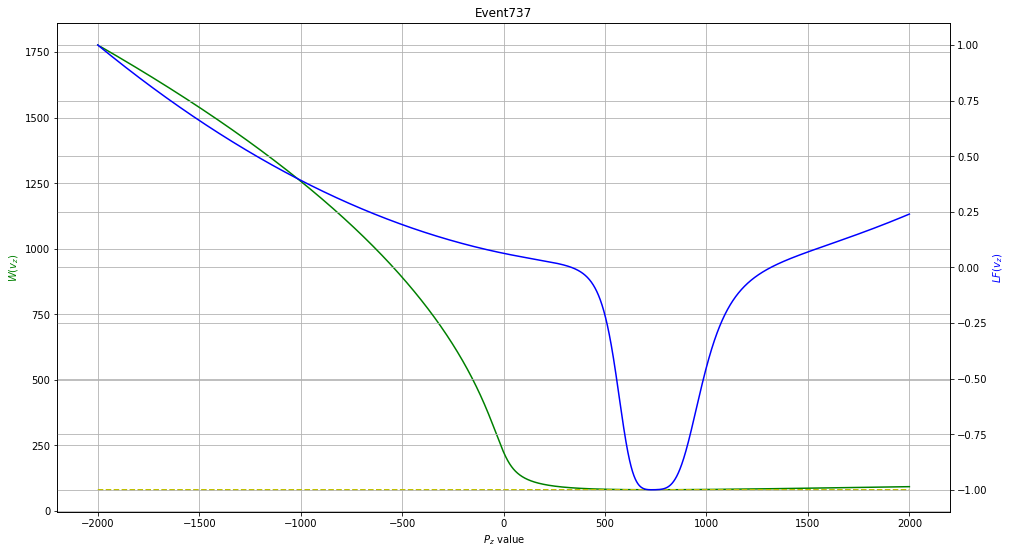

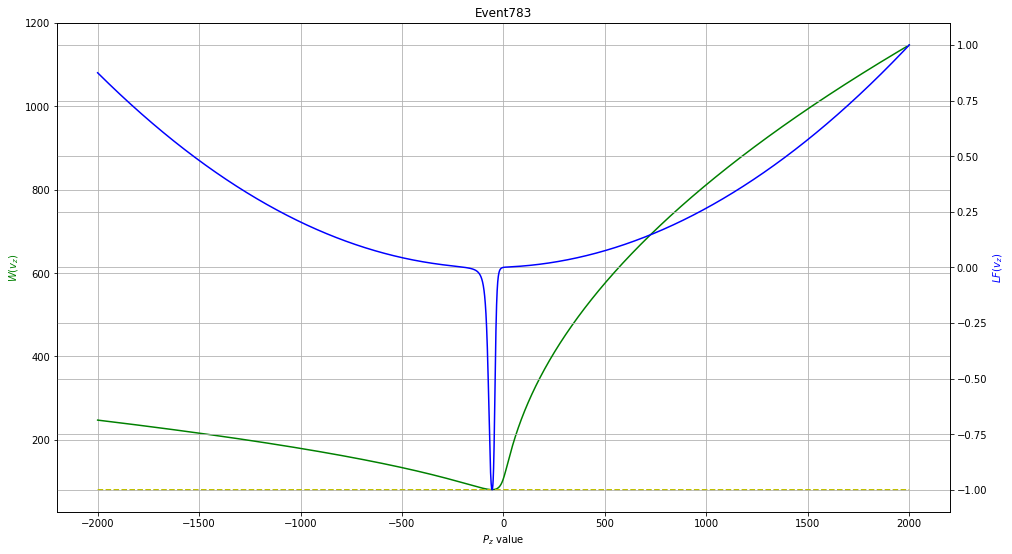

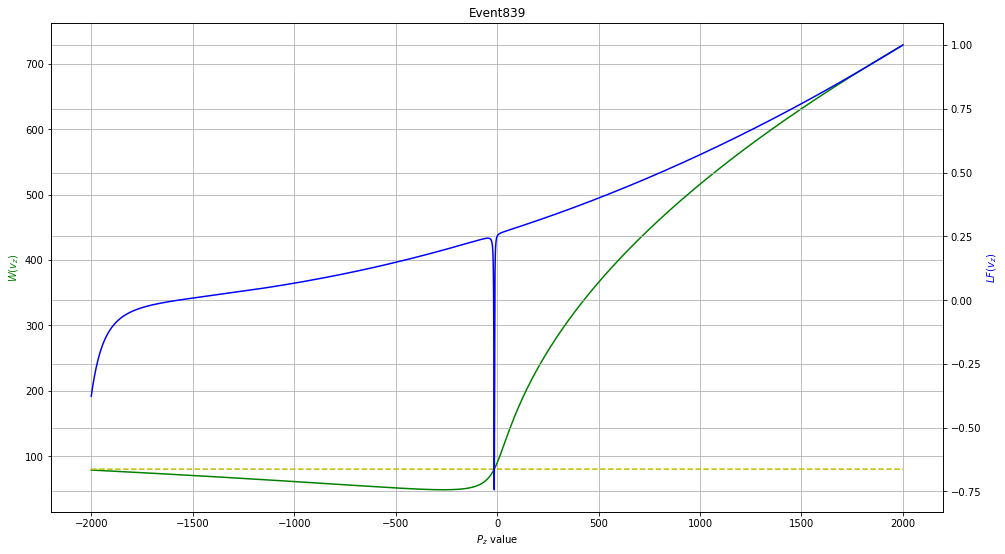

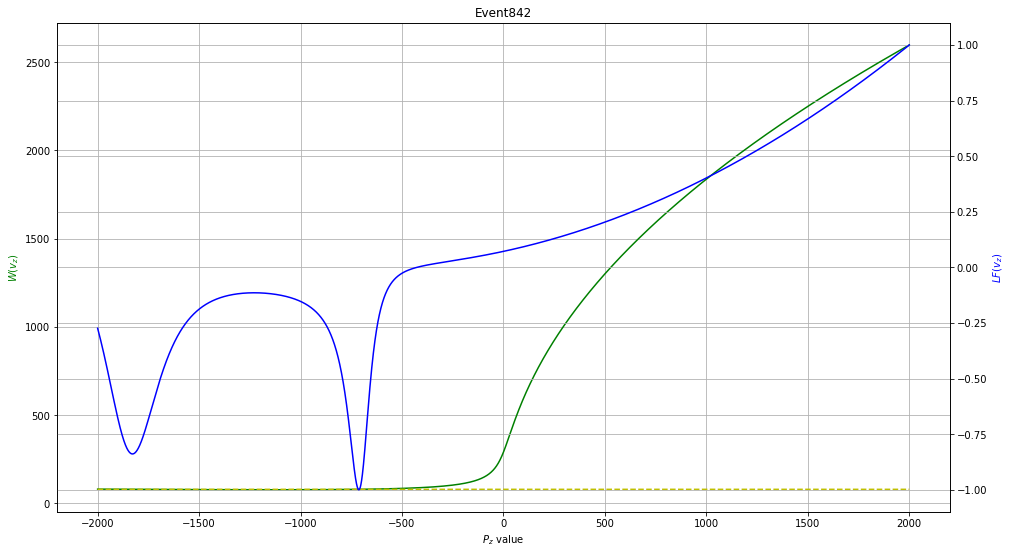

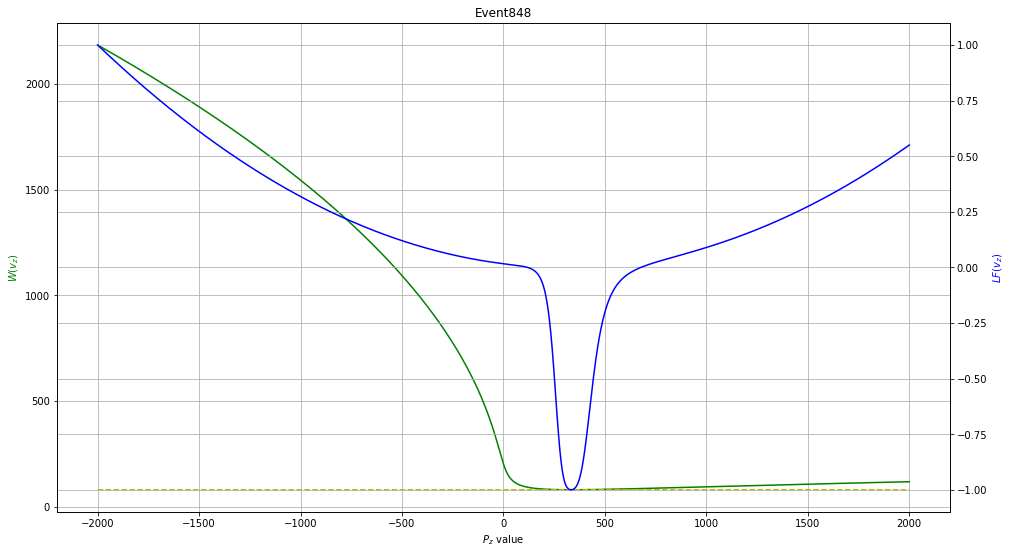

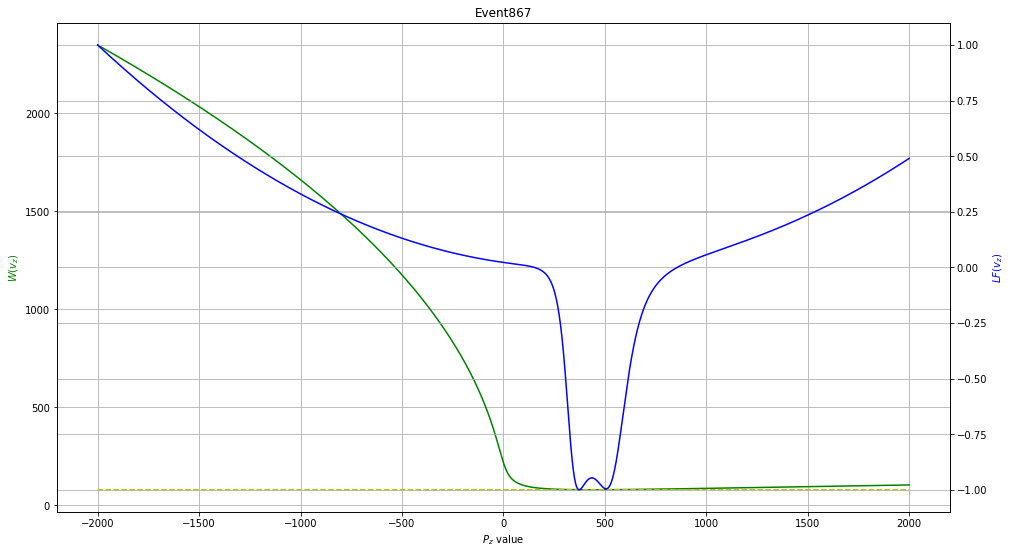

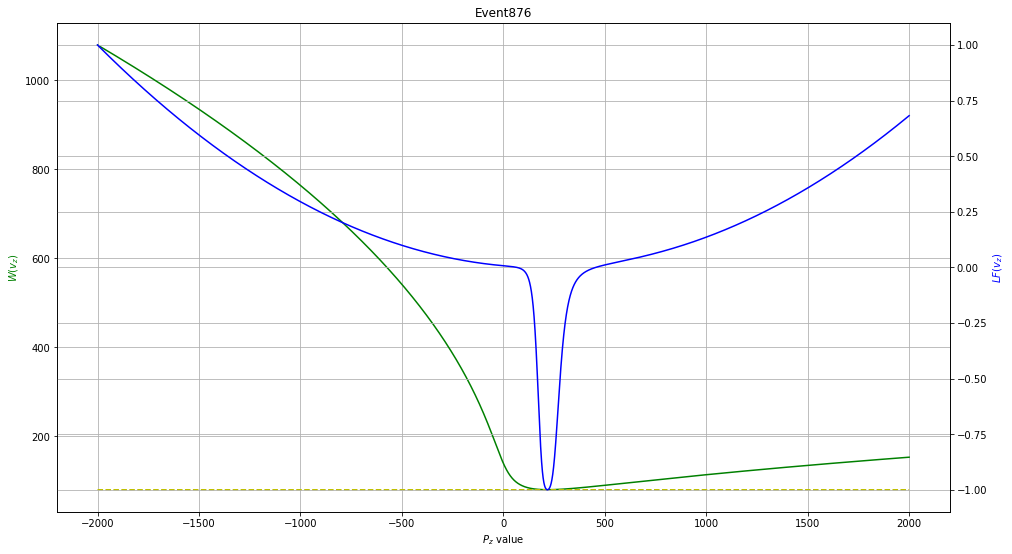

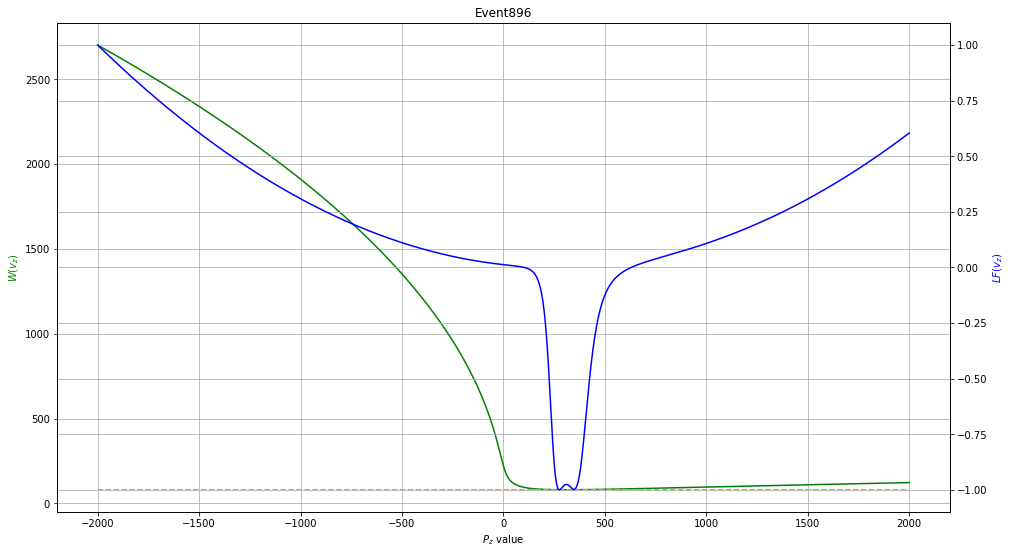

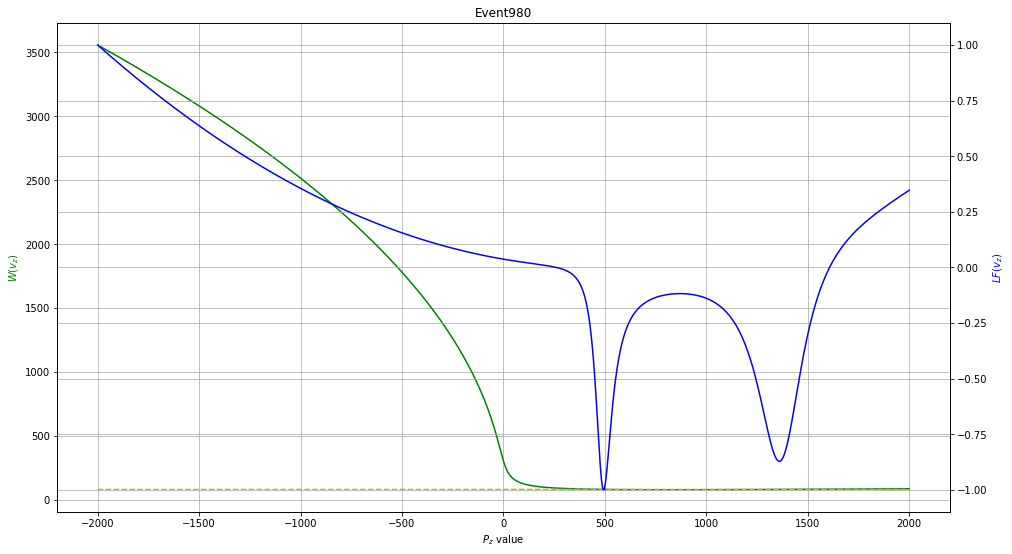

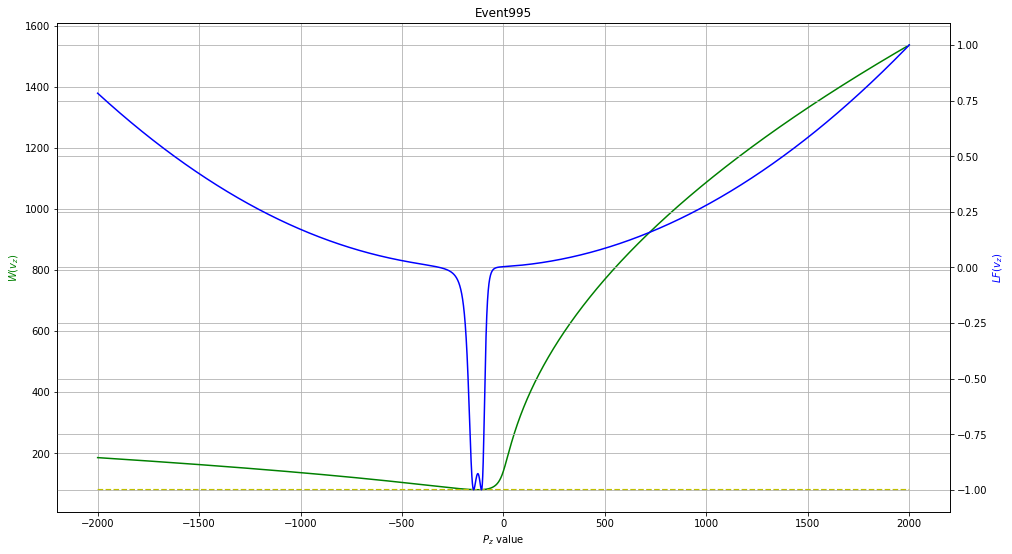

In [64]:
vz_range = np.linspace(-2000,2000,10000)

for i in range(0,len(wrong_index)):
    showPlots(wrong_index[i],vz_range)


## Minimizing - random normalisation

In [9]:
# Range of vz values in the data
pzmsure = np.empty((0,3), int)
for i in range(1,1001):
    pz = globals()[f'event{i}'].Pz[5]
    pzmsure = np.append(pzmsure,globals()[f'event{i}'].Pz[5])
    
a =max(pzmsure)
b =min(pzmsure)
print(a,b)
    
    

3099.80785 -2081.47976


In [15]:
pzrecon = np.empty((0,3), int)
pzmsure = np.empty((0,3), int)
guess_arr = np.empty((0,3), int) # brute force way
vz_range = np.linspace(-3150,3150,10000)

for i in range(1,1001):
   
    
    neutrinoPx = - globals()[f'event{i}'].Px[6] - globals()[f'event{i}'].Px[7] - globals()[f'event{i}'].Px[8] 
    neutrinoPy = - globals()[f'event{i}'].Py[6] - globals()[f'event{i}'].Py[7] - globals()[f'event{i}'].Py[8]
    testp_muon = np.sqrt(globals()[f'event{i}'].Px[6]**2 + globals()[f'event{i}'].Py[6]**2 + globals()[f'event{i}'].Pz[6]**2)
    protnpz1 = globals()[f'event{i}'].Pz[0] 
    protnpz2 = globals()[f'event{i}'].Pz[1]
    sig1 = 2.5 + 50* ((6500 - abs(protnpz1))/abs(protnpz1))
    sig2 = 2.5 + 50* ((6500 - abs(protnpz2))/abs(protnpz2))
    protnpz1 = protnpz1 + np.random.normal(0,sig1) # adding error
    protnpz2 = protnpz2 + np.random.normal(0,sig2)

    w = 80.318
    gamma = 2

    
    def pztot(vz): #Total momentum along Z
        return protnpz1+ protnpz2 + vz + globals()[f'event{i}'].Pz[6]+globals()[f'event{i}'].Pz[7]+globals()[f'event{i}'].Pz[8]

    def W(vz): # W function
        return np.sqrt(2*testp_muon*np.sqrt(neutrinoPx**2+neutrinoPy**2+vz**2)-2*(globals()[f'event{i}'].Px[6]*neutrinoPx+globals()[f'event{i}'].Py[6]*neutrinoPy+globals()[f'event{i}'].Pz[6]*vz))

    def LF1(vz): # First Loss Function Term
        return (pztot(vz)**2)/(sig1**2 + sig2**2)

    def LF2(vz,minimum_width): # Second Loss Function Term
        return 1/((W(vz)**2 - w**2)**2 + w**2 * minimum_width)
    
    def LF(vz,constant,gamma):
        A = constant
        return (10*((pztot(vz))**2)/((sig1)**2 + (sig2)**2)) -(0.5*0.5*10**11/(((W(vz)**2) - w**2)**2 + w**2 * 4))
    
    # Normalisation constant
    first_term = LF1(vz_range)
    ft_range = abs(max(first_term)-min(first_term))
    second_term = LF2(vz_range, 4)
    st_range = abs(max(second_term)- min(second_term))
    #normalisation = ft_range / st_range
    normalisation = 0.5*10**8
    
    # Finding minimum of LF to get initial guess
    LF_arr = LF(vz_range,normalisation,gamma)
    minimun_loc = np.where(LF_arr == LF_arr.min()) 
    initial_guess = vz_range[minimun_loc]
    minima = opt.minimize(LF,globals()[f'event{i}'].Pz[5], args=(normalisation,gamma)).x
    pzrecon = np.append(pzrecon,minima)
    pzmsure = np.append(pzmsure,globals()[f'event{i}'].Pz[5])
    guess_arr = np.append(guess_arr,initial_guess)
    if abs(minima - initial_guess)> 10:
        
        print(f"for event{i} guess is {initial_guess} reconstructed is {minima} actual is {globals()[f'event{i}'].Pz[5]}")

for event2 guess is [-360.71107111] reconstructed is [-26.31466793] actual is -26.5114289
for event6 guess is [-189.33393339] reconstructed is [14.49241837] actual is 14.307303699999999
for event10 guess is [80.3330333] reconstructed is [8.35421632] actual is 8.31658121
for event13 guess is [41.26912691] reconstructed is [17.0852138] actual is 17.2417763
for event19 guess is [-59.5409541] reconstructed is [-31.65130373] actual is -34.2310451
for event32 guess is [-1007.78577858] reconstructed is [-6.99557924] actual is -6.75864108
for event35 guess is [140.1890189] reconstructed is [43.43449683] actual is 42.87217570000001
for event43 guess is [-24.25742574] reconstructed is [-11.32579364] actual is -12.2895416
for event48 guess is [503.73537354] reconstructed is [3.03885328] actual is 3.31190701
for event71 guess is [-833.25832583] reconstructed is [-13.88769572] actual is -12.8722864
for event73 guess is [157.83078308] reconstructed is [-1.21433199] actual is -1.00261254
for event74 

for event509 guess is [574.30243024] reconstructed is [-4.21030376] actual is -4.3715435
for event511 guess is [-242.88928893] reconstructed is [12.68496221] actual is 12.732791
for event521 guess is [10.3960396] reconstructed is [-10.24518733] actual is -10.5475547
for event523 guess is [423.71737174] reconstructed is [-15.88143913] actual is -15.8359378
for event525 guess is [100.4950495] reconstructed is [17.63990717] actual is 17.606731399999997
for event539 guess is [-24.25742574] reconstructed is [6.91570122] actual is 4.24366757
for event564 guess is [121.28712871] reconstructed is [-61.84702392] actual is -61.843784899999996
for event567 guess is [-11.65616562] reconstructed is [5.08393833] actual is 5.29973088
for event575 guess is [32.44824482] reconstructed is [13.20362012] actual is 12.825342
for event582 guess is [302.74527453] reconstructed is [-25.81037167] actual is -25.8833937
for event587 guess is [-143.96939694] reconstructed is [-19.34424691] actual is -19.595304199

The rms of the distribution is  7.781544209905896


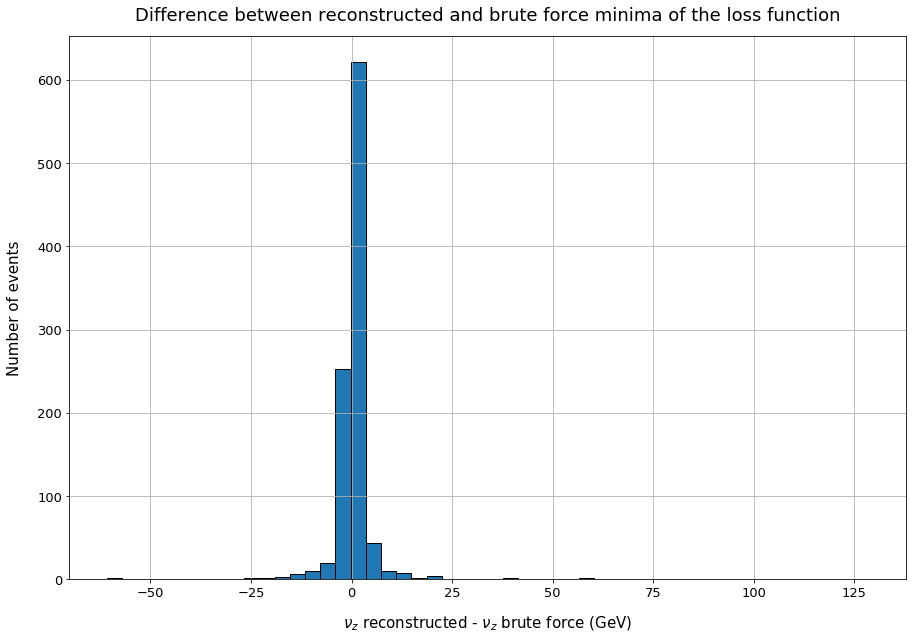

In [16]:
## Difference between measured & reconstructed for neutrino ##
diffpz = pzrecon-pzmsure
plt.figure(figsize=[15,10])
plt.hist(diffpz,bins = 50, ec='black')
plt.grid(True)
plt.xlabel(r"$\nu_z$ reconstructed - $\nu_z$ brute force (GeV)",labelpad = 15, size= 15)
plt.xticks(fontsize= 13 )
plt.yticks(fontsize=13)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title(r"Difference between reconstructed and brute force minima of the loss function",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffpz**2)) # rms of the distribution
print("The rms of the distribution is ", rms)
#plt.savefig("Hist of recons 2p.png")

The rms of the distribution is  109.21630647795128


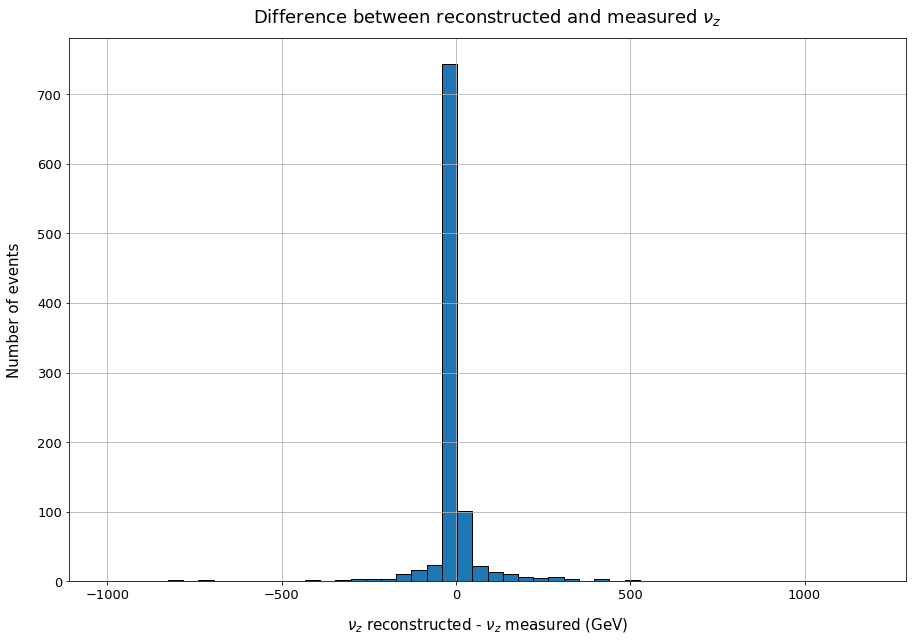

In [17]:
## Difference between measured & reconstructed for neutrino ##
diffpz = guess_arr-pzmsure
plt.figure(figsize=[15,10])
plt.hist(diffpz,bins = 50, ec='black')
plt.grid(True)
plt.xlabel(r"$\nu_z$ reconstructed - $\nu_z$ measured (GeV)",labelpad = 15, size= 15)
plt.xticks(fontsize= 13 )
plt.yticks(fontsize=13)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title(r"Difference between reconstructed and measured $\nu_z$",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffpz**2)) # rms of the distribution
print("The rms of the distribution is ", rms)
#plt.savefig("Hist of recons 2p.png")

The rms of the distribution is  108.94215165316328


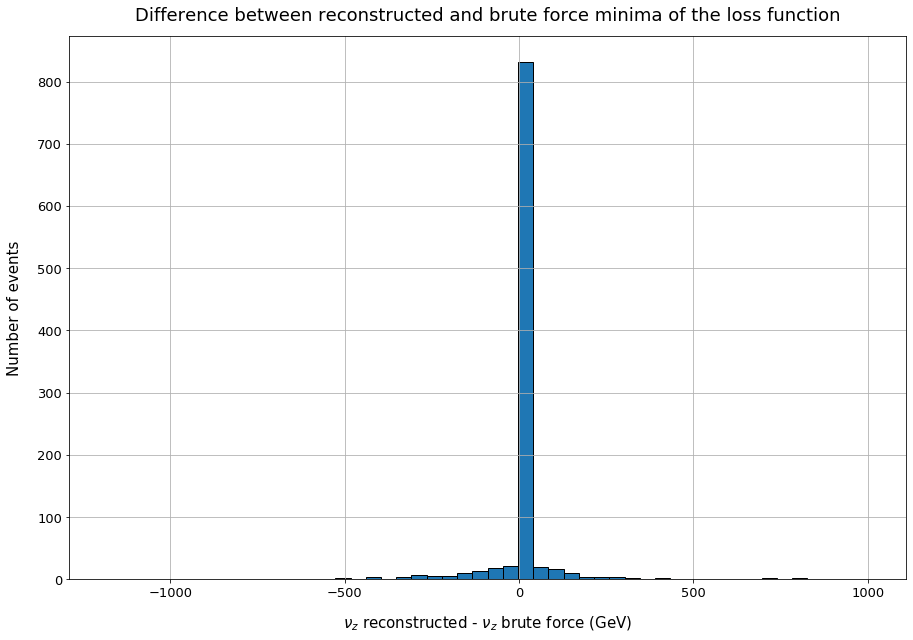

In [18]:
## Difference between measured & reconstructed for neutrino ##
diffpz = pzrecon-guess_arr
plt.figure(figsize=[15,10])
plt.hist(diffpz,bins = 50, ec='black')
plt.grid(True)
plt.xlabel(r"$\nu_z$ reconstructed - $\nu_z$ brute force (GeV)",labelpad = 15, size= 15)
plt.xticks(fontsize= 13 )
plt.yticks(fontsize=13)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title(r"Difference between reconstructed and brute force minima of the loss function",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffpz**2)) # rms of the distribution
print("The rms of the distribution is ", rms)
#plt.savefig("Hist of recons 2p.png")

## Minimizing - normalising using ranges of the terms


In [11]:
pzrecon = np.empty((0,3), int)
pzmsure = np.empty((0,3), int)
guess_arr = np.empty((0,3), int) # brute force way
vz_range = np.linspace(-3150,3150,10000)

for i in range(1,1001):
   
    
    neutrinoPx = - globals()[f'event{i}'].Px[6] - globals()[f'event{i}'].Px[7] - globals()[f'event{i}'].Px[8] 
    neutrinoPy = - globals()[f'event{i}'].Py[6] - globals()[f'event{i}'].Py[7] - globals()[f'event{i}'].Py[8]
    testp_muon = np.sqrt(globals()[f'event{i}'].Px[6]**2 + globals()[f'event{i}'].Py[6]**2 + globals()[f'event{i}'].Pz[6]**2)
    protnpz1 = globals()[f'event{i}'].Pz[0] 
    protnpz2 = globals()[f'event{i}'].Pz[1]
    sig1 = 2.5 + 50* ((6500 - abs(protnpz1))/abs(protnpz1))
    sig2 = 2.5 + 50* ((6500 - abs(protnpz2))/abs(protnpz2))
    protnpz1 = protnpz1 + np.random.normal(0,sig1) # adding error
    protnpz2 = protnpz2 + np.random.normal(0,sig2)
    w = 80.318
    gamma = 2

    
    def pztot(vz): #Total momentum along Z
        return protnpz1+ protnpz2 + vz + globals()[f'event{i}'].Pz[6]+globals()[f'event{i}'].Pz[7]+globals()[f'event{i}'].Pz[8]

    def W(vz): # W function
        return np.sqrt(2*testp_muon*np.sqrt(neutrinoPx**2+neutrinoPy**2+vz**2)-2*(globals()[f'event{i}'].Px[6]*neutrinoPx+globals()[f'event{i}'].Py[6]*neutrinoPy+globals()[f'event{i}'].Pz[6]*vz))

    def LF1(vz): # First Loss Function Term
        return (pztot(vz)**2)/(sig1**2 + sig2**2)

    def LF2(vz,minimum_width): # Second Loss Function Term
        return 1/((W(vz)**2 - w**2)**2 + w**2 * minimum_width)
    
    def LF(vz,constant,gamma):
        A = constant
        return (((pztot(vz))**2)/((sig1)**2 + (sig2)**2)) -(A/(((W(vz)**2) - w**2)**2 + w**2 *4))
    
    # Normalisation constant
    first_term = LF1(vz_range)
    ft_range = abs(max(first_term)-min(first_term))
    second_term = LF2(vz_range, 4)
    st_range = abs(max(second_term)- min(second_term))
    normalisation = ft_range / st_range
    #normalisation = 0.5*10**8
    
    # Finding minimum of LF to get initial guess
    LF_arr = LF(vz_range,normalisation,gamma)
    minimun_loc = np.where(LF_arr == LF_arr.min()) 
    initial_guess = vz_range[minimun_loc]
    minima = opt.minimize(LF,globals()[f'event{i}'].Pz[5], args=(normalisation,gamma)).x
    pzrecon = np.append(pzrecon,minima)
    pzmsure = np.append(pzmsure,globals()[f'event{i}'].Pz[5])
    guess_arr = np.append(guess_arr,initial_guess)
    if abs(minima - initial_guess)> 10:
        
        print(f"for event{i} guess is {initial_guess} reconstructed is {minima} actual is {globals()[f'event{i}'].Pz[5]}")

for event2 guess is [-360.71107111] reconstructed is [-26.31466756] actual is -26.5114289
for event6 guess is [-189.33393339] reconstructed is [14.49241257] actual is 14.307303699999999
for event10 guess is [80.3330333] reconstructed is [8.35418635] actual is 8.31658121
for event13 guess is [41.26912691] reconstructed is [17.08531258] actual is 17.2417763
for event19 guess is [-59.5409541] reconstructed is [-31.65120883] actual is -34.2310451
for event32 guess is [-1007.15571557] reconstructed is [-6.99557933] actual is -6.75864108
for event35 guess is [140.1890189] reconstructed is [43.43449909] actual is 42.87217570000001
for event43 guess is [-24.25742574] reconstructed is [-11.32578777] actual is -12.2895416
for event49 guess is [-489.24392439] reconstructed is [-46.03309156] actual is -46.7230414
for event66 guess is [-176.73267327] reconstructed is [61.63200148] actual is 61.55680329999999
for event71 guess is [-833.25832583] reconstructed is [-13.88769602] actual is -12.8722864


for event428 guess is [150.90009001] reconstructed is [3.61568328] actual is 3.31533053
for event431 guess is [-48.82988299] reconstructed is [39.81393889] actual is 40.0093296
for event432 guess is [320.3870387] reconstructed is [-15.17857624] actual is -15.1992715
for event446 guess is [46.93969397] reconstructed is [71.81801221] actual is 68.8314025
for event447 guess is [-63.95139514] reconstructed is [80.52541025] actual is 81.1609238
for event454 guess is [-123.17731773] reconstructed is [-19.38007779] actual is -19.3589904
for event462 guess is [41.26912691] reconstructed is [7.05989843] actual is 7.75677622
for event463 guess is [138.29882988] reconstructed is [-6.85216928] actual is -6.82872119
for event465 guess is [247.92979298] reconstructed is [-26.34331565] actual is -26.369133500000004
for event476 guess is [69.6219622] reconstructed is [-11.22647541] actual is -11.6199505
for event477 guess is [13.54635464] reconstructed is [-30.28964602] actual is -29.486499900000002
f

for event798 guess is [-387.17371737] reconstructed is [10.79394054] actual is 10.8211856
for event807 guess is [-100.4950495] reconstructed is [34.58933265] actual is 34.550669899999995
for event811 guess is [23.62736274] reconstructed is [-0.93083959] actual is -1.07942274
for event815 guess is [-34.96849685] reconstructed is [-21.30746853] actual is -26.048132199999998
for event817 guess is [235.32853285] reconstructed is [-9.56478641] actual is -9.575576
for event818 guess is [-69.6219622] reconstructed is [-27.71527882] actual is -28.324686199999995
for event822 guess is [96.08460846] reconstructed is [-73.19836098] actual is -73.11003070000001
for event823 guess is [-63.95139514] reconstructed is [-6.83568137] actual is -5.91705546
for event831 guess is [-29.29792979] reconstructed is [11.7398232] actual is 11.7016228
for event837 guess is [-43.78937894] reconstructed is [-14.52263951] actual is -14.304879699999999
for event838 guess is [133.88838884] reconstructed is [-16.222064

The rms of the distribution is  7.703746804615013


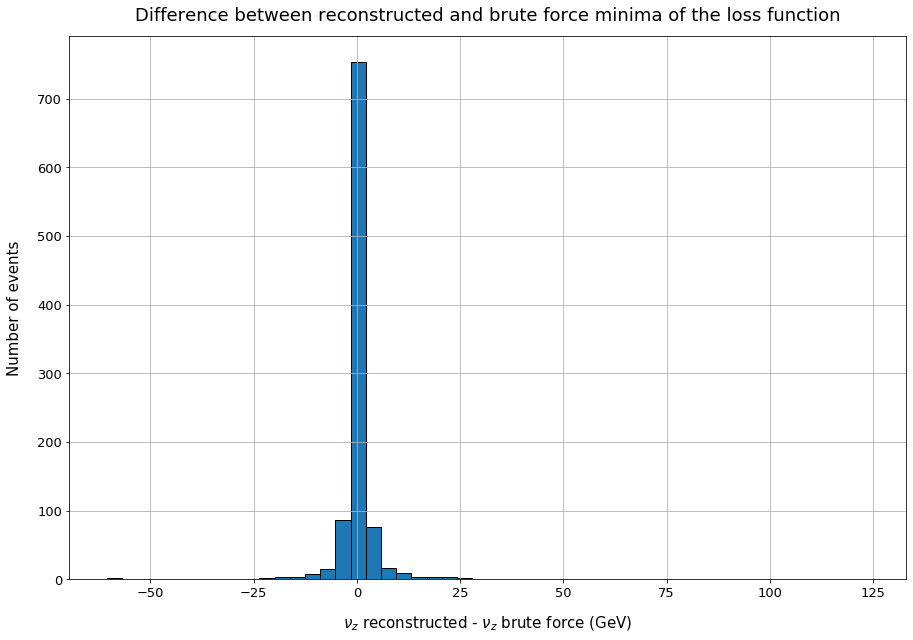

In [12]:
## Difference between measured & reconstructed for neutrino ##
diffpz = pzrecon-pzmsure
plt.figure(figsize=[15,10])
plt.hist(diffpz,bins = 50, ec='black')
plt.grid(True)
plt.xlabel(r"$\nu_z$ reconstructed - $\nu_z$ brute force (GeV)",labelpad = 15, size= 15)
plt.xticks(fontsize= 13 )
plt.yticks(fontsize=13)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title(r"Difference between reconstructed and brute force minima of the loss function",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffpz**2)) # rms of the distribution
print("The rms of the distribution is ", rms)
#plt.savefig("Hist of recons 2p.png")

The rms of the distribution is  131.50052055887144


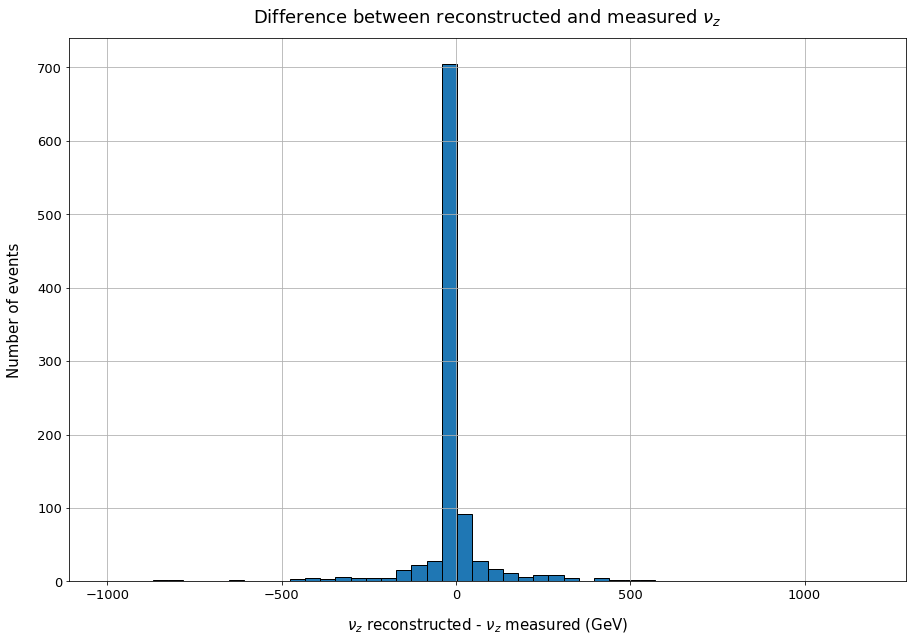

In [13]:
## Difference between measured & reconstructed for neutrino ##
diffpz = guess_arr-pzmsure
plt.figure(figsize=[15,10])
plt.hist(diffpz,bins = 50, ec='black')
plt.grid(True)
plt.xlabel(r"$\nu_z$ reconstructed - $\nu_z$ measured (GeV)",labelpad = 15, size= 15)
plt.xticks(fontsize= 13 )
plt.yticks(fontsize=13)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title(r"Difference between reconstructed and measured $\nu_z$",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffpz**2)) # rms of the distribution
print("The rms of the distribution is ", rms)
#plt.savefig("Hist of recons 2p.png")

The rms of the distribution is  131.29367654273997


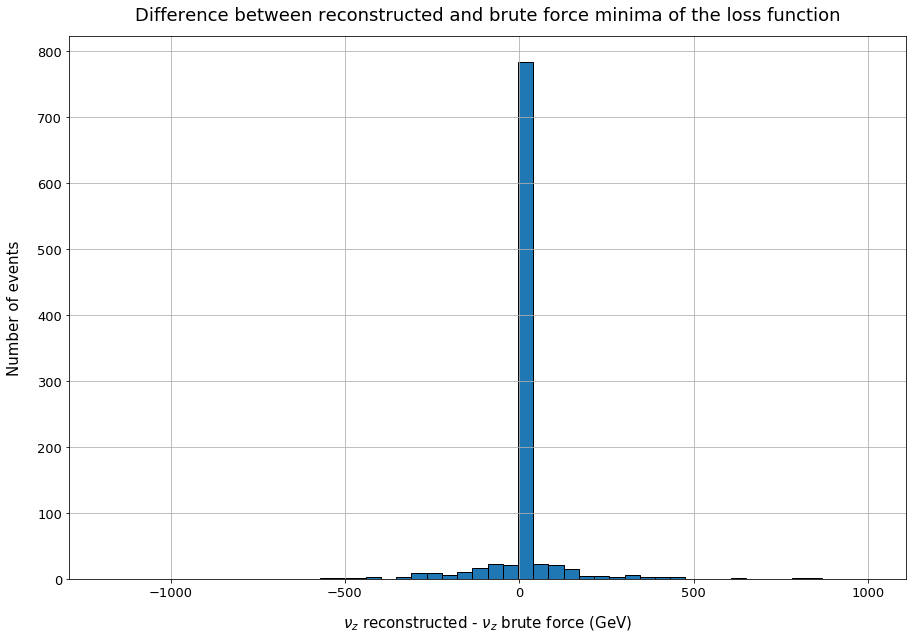

In [14]:
## Difference between measured & reconstructed for neutrino ##
diffpz = pzrecon-guess_arr
plt.figure(figsize=[15,10])
plt.hist(diffpz,bins = 50, ec='black')
plt.grid(True)
plt.xlabel(r"$\nu_z$ reconstructed - $\nu_z$ brute force (GeV)",labelpad = 15, size= 15)
plt.xticks(fontsize= 13 )
plt.yticks(fontsize=13)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title(r"Difference between reconstructed and brute force minima of the loss function",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffpz**2)) # rms of the distribution
print("The rms of the distribution is ", rms)
#plt.savefig("Hist of recons 2p.png")

## minmizing first term

We investigate the effect of minimzing the firt term on its own


In [90]:
pzrecon = np.empty((0,3), int)
pzmsure = np.empty((0,3), int)
guess_arr = np.empty((0,3), int) # brute force way
vz_range = np.linspace(-3150,3150,100000)

for i in range(1,1001):
   
    
    neutrinoPx = - globals()[f'event{i}'].Px[6] - globals()[f'event{i}'].Px[7] - globals()[f'event{i}'].Px[8] 
    neutrinoPy = - globals()[f'event{i}'].Py[6] - globals()[f'event{i}'].Py[7] - globals()[f'event{i}'].Py[8]
    testp_muon = np.sqrt(globals()[f'event{i}'].Px[6]**2 + globals()[f'event{i}'].Py[6]**2 + globals()[f'event{i}'].Pz[6]**2)
    protnpz1 = globals()[f'event{i}'].Pz[0] 
    protnpz2 = globals()[f'event{i}'].Pz[1]
    sig1 = 2.5 + 50* ((6500 - abs(protnpz1))/abs(protnpz1))
    sig2 = 2.5 + 50* ((6500 - abs(protnpz2))/abs(protnpz2))
    protnpz1 = protnpz1 + np.random.normal(0,sig1) # adding error
    protnpz2 = protnpz2 + np.random.normal(0,sig2)

    w = 80.318
    gamma = 2

    def W(vz): # W function
        return np.sqrt(2*testp_muon*np.sqrt(neutrinoPx**2+neutrinoPy**2+vz**2)-2*(globals()[f'event{i}'].Px[6]*neutrinoPx+globals()[f'event{i}'].Py[6]*neutrinoPy+globals()[f'event{i}'].Pz[6]*vz))

    def pztot(vz): #Total momentum along Z
        return protnpz1+ protnpz2 + vz + globals()[f'event{i}'].Pz[6]+globals()[f'event{i}'].Pz[7]+globals()[f'event{i}'].Pz[8]

  
    def LF2(vz): # First Loss Function Term
        return (pztot(vz)**2)/(sig1**2 + sig2**2)

    def LF1(vz): # Second Loss Function Term
        return -(1)/((W(vz)**2 - w**2)**2 +4*( w**2))
    

    

    
    # Finding minimum of LF1 to get initial guess
    LF_arr = LF1(vz_range)
    minimun_loc = np.where(LF_arr == LF_arr.min()) 
    initial_guess = vz_range[minimun_loc]
    minima = opt.minimize(LF1,globals()[f'event{i}'].Pz[5]).x
    pzrecon = np.append(pzrecon,minima)
    pzmsure = np.append(pzmsure,globals()[f'event{i}'].Pz[5])
    guess_arr = np.append(guess_arr,initial_guess)

    
## using truth as guess gives rms = 0.2
## using brute force as a guess gives rms= 521

The rms of the distribution is  0.20298189360651456


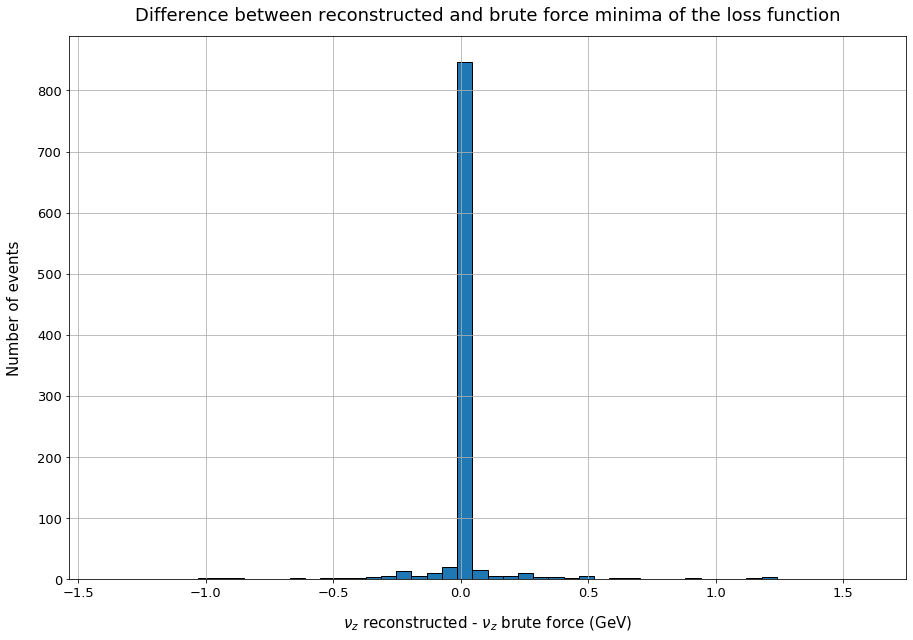

In [91]:
## Difference between measured & reconstructed for neutrino ##
diffpz = pzrecon-pzmsure
plt.figure(figsize=[15,10])
plt.hist(diffpz,bins = 50, ec='black')
plt.grid(True)
plt.xlabel(r"$\nu_z$ reconstructed - $\nu_z$ brute force (GeV)",labelpad = 15, size= 15)
plt.xticks(fontsize= 13 )
plt.yticks(fontsize=13)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title(r"Difference between reconstructed and brute force minima of the loss function",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffpz**2)) # rms of the distribution
print("The rms of the distribution is ", rms)
#plt.savefig("Hist of recons 2p.png")

The rms of the distribution is  521.3795555655181


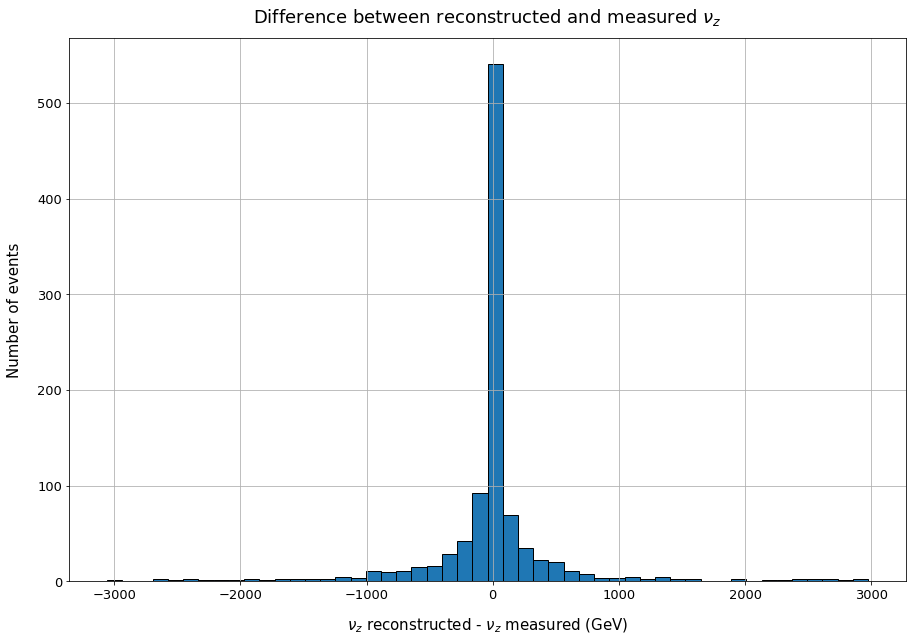

In [86]:
## Difference between measured & reconstructed for neutrino ##
diffpz = guess_arr-pzmsure
plt.figure(figsize=[15,10])
plt.hist(diffpz,bins = 50, ec='black')
plt.grid(True)
plt.xlabel(r"$\nu_z$ reconstructed - $\nu_z$ measured (GeV)",labelpad = 15, size= 15)
plt.xticks(fontsize= 13 )
plt.yticks(fontsize=13)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title(r"Difference between reconstructed and measured $\nu_z$",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffpz**2)) # rms of the distribution
print("The rms of the distribution is ", rms)
#plt.savefig("Hist of recons 2p.png")

The rms of the distribution is  0.0005364044115985171


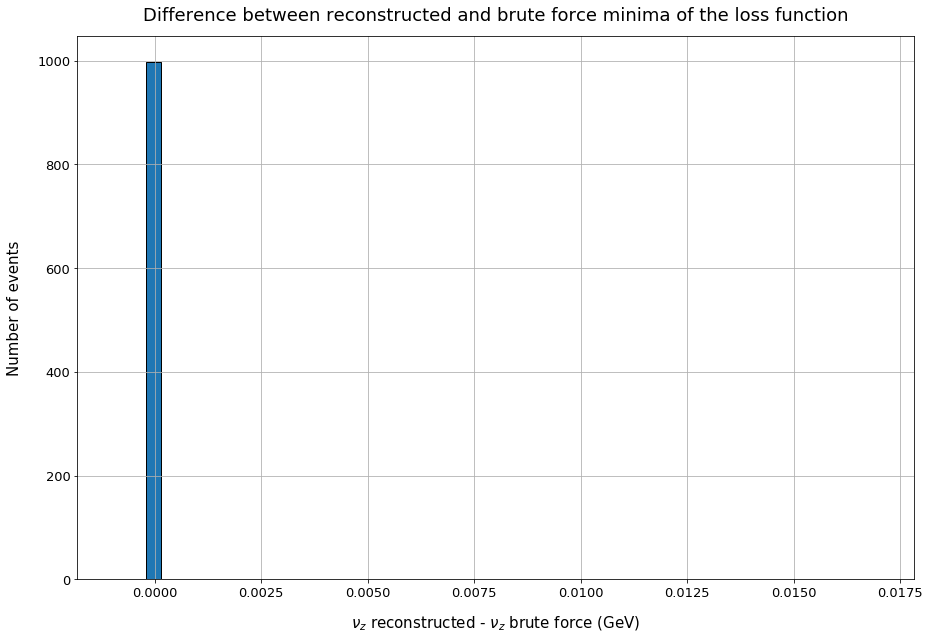

In [87]:
## Difference between measured & reconstructed for neutrino ##
diffpz = pzrecon-guess_arr
plt.figure(figsize=[15,10])
plt.hist(diffpz,bins = 50, ec='black')
plt.grid(True)
plt.xlabel(r"$\nu_z$ reconstructed - $\nu_z$ brute force (GeV)",labelpad = 15, size= 15)
plt.xticks(fontsize= 13 )
plt.yticks(fontsize=13)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title(r"Difference between reconstructed and brute force minima of the loss function",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffpz**2)) # rms of the distribution
print("The rms of the distribution is ", rms)
#plt.savefig("Hist of recons 2p.png")

so it seems like the brute force minima went wrong for some events so I settled for using the truth as initial guess. Also we need to smear the proton pz values !!